<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>SafeML Implementation for German Traffic Sign Recognition Benchmark (GTSRB)</b></div>

<div style="text-align:center;">
  <img src="https://raw.githubusercontent.com/ISorokos/SafeML/master/SafeML_Logo.png" alt="safeml logo">
</div>

In this example, we try to show how SafeML approach can be used for German Traffic Sign Recognition.We have used an existing code from the following URL that do the traffic sign classification using Convolutional Neural Networks (CNNs) with about 97% accuracy. Then the SafeML part is added to show how the safety of the approach can be monitored:

Here is the table of content:
* Defining the required libraries and loading the german traffic sgin recognition dataset.
* Separating Train, Test and Validation Data
* Defining the CNN model and its architecture.
* Training the model and calculating its accuracy
* Applying the model on test data
* Comparing the true labels with predicted labels and using the statistical parametric mapping (as the SafeML method)

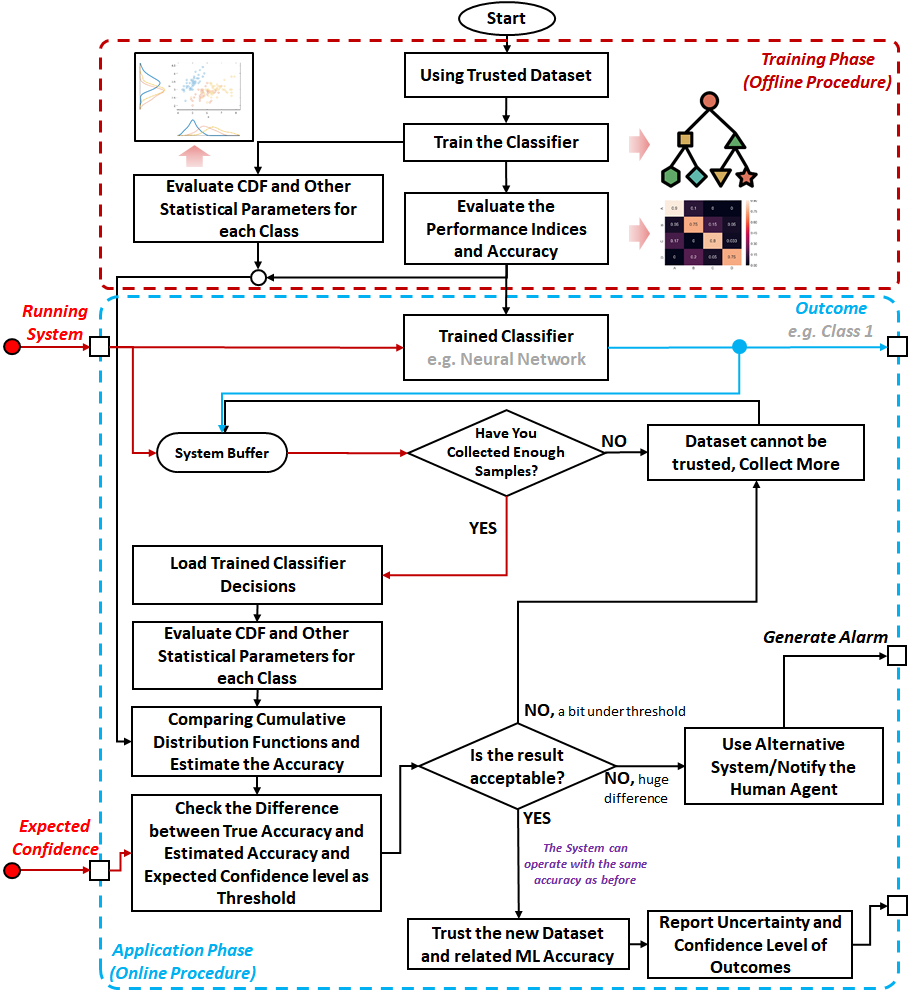

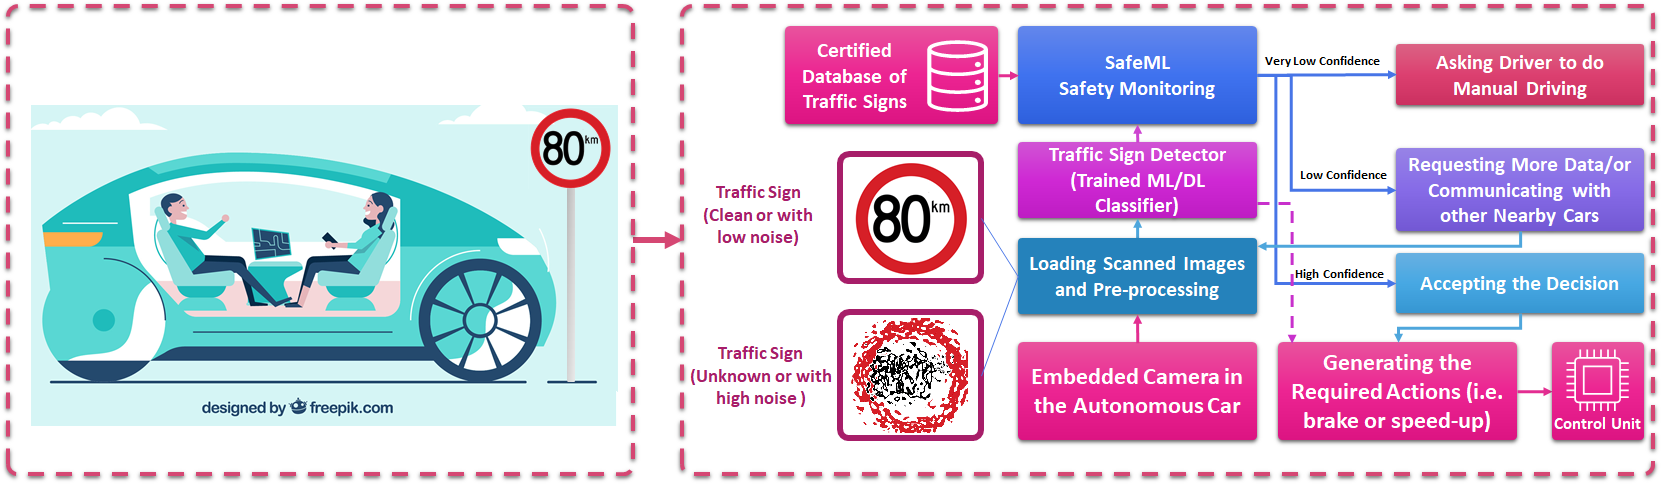

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Table of content</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
<a id="TOC"></a>
## Table of Content
    
* [Importing Required Libraries](#lib)
* [Reading Dataset](#read_data)
* [Splitting the Dataset](#split)
* [Defining the CNN Model](#model)
* [Training the Model and Calculating its Accuracy](#train)
* [Using SafeML](#safeml)
* [Plotting the SafeML Results](#plot)
* [Statistical Parametric Mapping (SPM)](#spm)    
* [Wasserstein Distance Measures](#wd)
* [Calculating Wilson Interval Confidence](#wic)
* [References](#ref)
* [Related GitHub Projects](#git)

<a id="lib"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Importing Required Libraries</b></div> 

In [1]:
# For pySankey plot
!pip install pySankey -q

In [2]:
# For using SafeML functions
!git clone https://github.com/ISorokos/SafeML.git

fatal: destination path 'SafeML' already exists and is not an empty directory.


In [3]:
import sys
sys.path.insert(1, './SafeML/Implementation_in_Python')

# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

<a id="read_data"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Reading the GTSRB Dataset</b></div> 

Reading the input images and putting them into a numpy array.

In [5]:
data=[]
labels=[]

height = 30
width = 30
channels = 3
classes = 43
n_inputs = height * width*channels

for i in range(classes) :
    path = "./../gtsrb-german-traffic-sign/Train/{0}/".format(i)
    #path = "C:/cmder/Python_Tests/GTSRB/Train/{0}/".format(i)
    print(path)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

./gtsrb-german-traffic-sign/Train/0/
./gtsrb-german-traffic-sign/Train/1/
./gtsrb-german-traffic-sign/Train/2/
./gtsrb-german-traffic-sign/Train/3/
./gtsrb-german-traffic-sign/Train/4/
./gtsrb-german-traffic-sign/Train/5/
./gtsrb-german-traffic-sign/Train/6/
./gtsrb-german-traffic-sign/Train/7/
./gtsrb-german-traffic-sign/Train/8/
./gtsrb-german-traffic-sign/Train/9/
./gtsrb-german-traffic-sign/Train/10/
./gtsrb-german-traffic-sign/Train/11/
./gtsrb-german-traffic-sign/Train/12/
./gtsrb-german-traffic-sign/Train/13/
./gtsrb-german-traffic-sign/Train/14/
./gtsrb-german-traffic-sign/Train/15/
./gtsrb-german-traffic-sign/Train/16/
./gtsrb-german-traffic-sign/Train/17/
./gtsrb-german-traffic-sign/Train/18/
./gtsrb-german-traffic-sign/Train/19/
./gtsrb-german-traffic-sign/Train/20/
./gtsrb-german-traffic-sign/Train/21/
./gtsrb-german-traffic-sign/Train/22/
./gtsrb-german-traffic-sign/Train/23/
./gtsrb-german-traffic-sign/Train/24/
./gtsrb-german-traffic-sign/Train/25/
./gtsrb-german-traffic

<a id="split"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Separating Train, Test and Validation Data</b></div> 
 
In this section, 20% of data is separated for test and validation and the rest is used for training. This section can be improved using methods like K-fold cross-validation. We tried to make it as simple as possible.

In [6]:
#Spliting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

#Using one hote encoding for the train and validation labels
from keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

<a id="model"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#008fff;overflow:hidden"><b>Defining the CNN Model</b></div> 

Here the CNN model's structure is defined. Regarding the loss function the categorical crossentropy is used, and the ADAM is selection for the network optimization.

In [7]:
#Definition of the CNN model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

<a id="train"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Training the Model and Calculating its Accuracy</b></div> 

In this section, the CNN model is trained and the accuracy plot is shown. 

Epoch 1/20
981/981 [==============================] - 42s 42ms/step - loss: 1.1897 - accuracy: 0.6638 - val_loss: 0.1560 - val_accuracy: 0.9666
Epoch 2/20
981/981 [==============================] - 42s 43ms/step - loss: 0.2289 - accuracy: 0.9291 - val_loss: 0.0662 - val_accuracy: 0.9860
Epoch 3/20
981/981 [==============================] - 43s 44ms/step - loss: 0.1439 - accuracy: 0.9565 - val_loss: 0.0372 - val_accuracy: 0.9913
Epoch 4/20
981/981 [==============================] - 49s 50ms/step - loss: 0.1016 - accuracy: 0.9687 - val_loss: 0.0462 - val_accuracy: 0.9872
Epoch 5/20
981/981 [==============================] - 54s 55ms/step - loss: 0.0838 - accuracy: 0.9759 - val_loss: 0.0305 - val_accuracy: 0.9927
Epoch 6/20
981/981 [==============================] - 52s 53ms/step - loss: 0.0677 - accuracy: 0.9792 - val_loss: 0.0295 - val_accuracy: 0.9923
Epoch 7/20
981/981 [==============================] - 46s 47ms/step - loss: 0.0646 - accuracy: 0.9811 - val_loss: 0.0246 - val_accuracy:

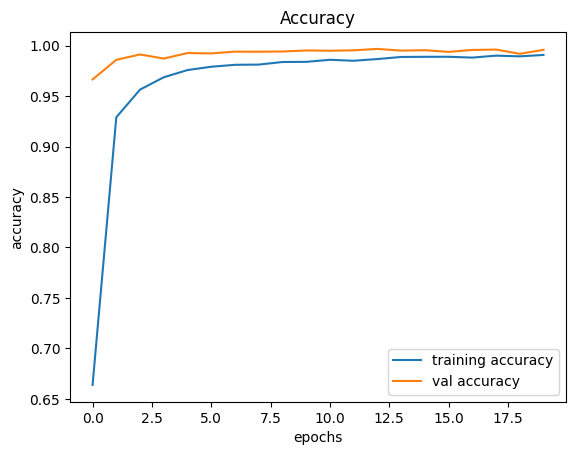

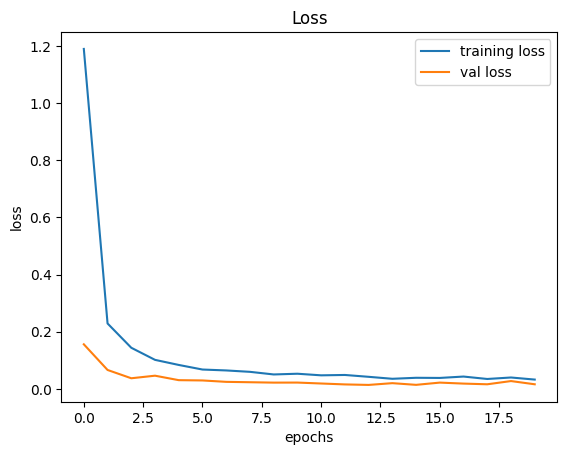

In [8]:
#using ten epochs for the training and saving the accuracy for each epoch
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val))

#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

<a id="test"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Testing the Model</b></div> 

Having trained the CNN model, the test data is used. The predicted decisions has been stored as "y_pred". As can be seen the accuracy of the model is about 0.97%.

In [9]:
#Predicting with the test data
y_test=pd.read_csv("./../gtsrb-german-traffic-sign/Test.csv")
# labels=y_test['Path'].as_matrix()
labels=y_test['Path'].to_numpy()
y_test=y_test['ClassId'].values

data=[]

for f in labels:
    image=cv2.imread('./../gtsrb-german-traffic-sign/Test/'+f.replace('Test/', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))

X_test=np.array(data)
X_test = X_test.astype('float32')/255 

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score

print(y_pred)

accuracy_score(y_test, y_pred)

395/395 [==============================] - 4s 11ms/step
[16  1 38 ...  6  7 10]


0.9714964370546318

<a id="acc_pysankey"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Visualizing the Confusion Matrix using Sankey Plot</b></div> 

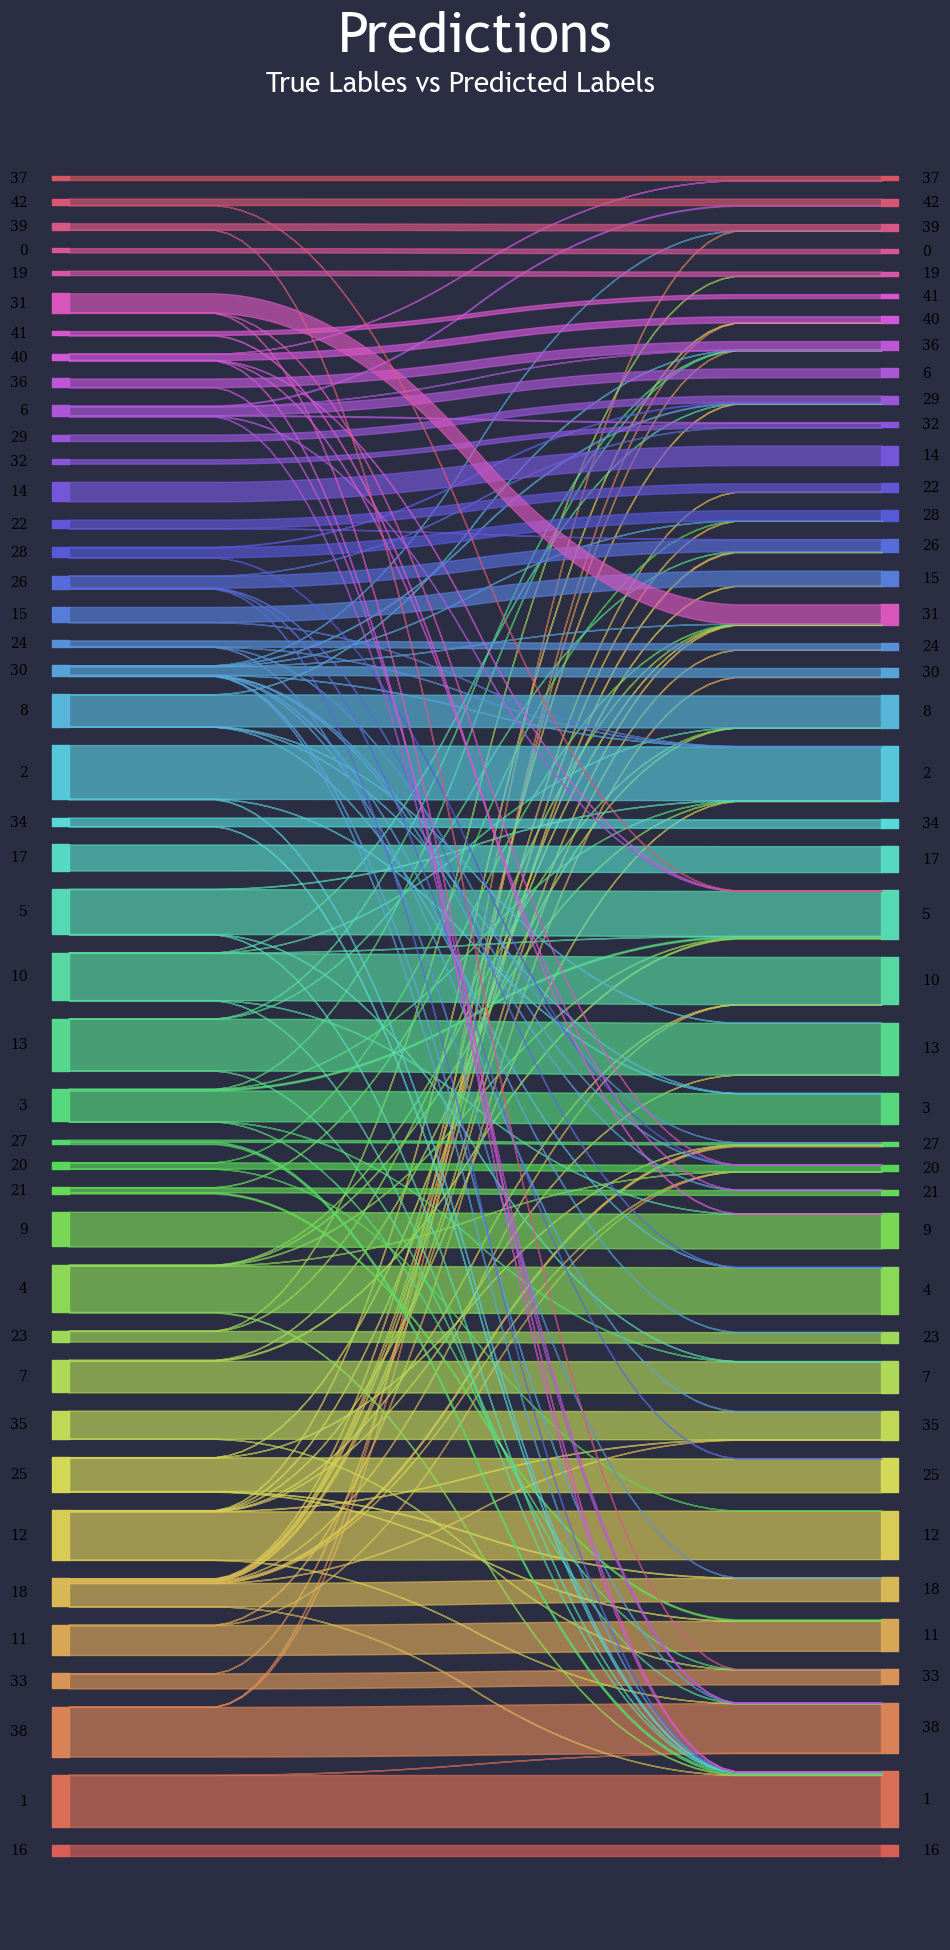

In [10]:
from pySankey.sankey import sankey

sankey(
    left=y_test, 
    right=y_pred, 
#     leftWeight= df_got["Season"], 
#     rightWeight=df_got["Season"], 
    aspect=10, fontsize=10
)

# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 24)

# Set the color of the background to white
fig.set_facecolor("#2b2d42")

#font color to white
plt.rcParams['text.color'] = 'white'

plt.rcParams['axes.titlecolor'] = 'white'

plt.rcParams['axes.labelcolor'] = 'white'

#Font to Trebuchet MS
plt.rcParams['font.family'] = 'Trebuchet MS'

#font size to 12
plt.rcParams['font.size'] = 30

#Title
plt.title("Predictions", fontsize=40, fontname='Trebuchet MS', pad=30)
#subtitle 
plt.suptitle("safeML_True Lables vs Predicted Labels", fontsize=20, fontname='Trebuchet MS', y=0.889)

# fig.savefig("True_vs_Wrong1.png", bbox_inches="tight", dpi=800)

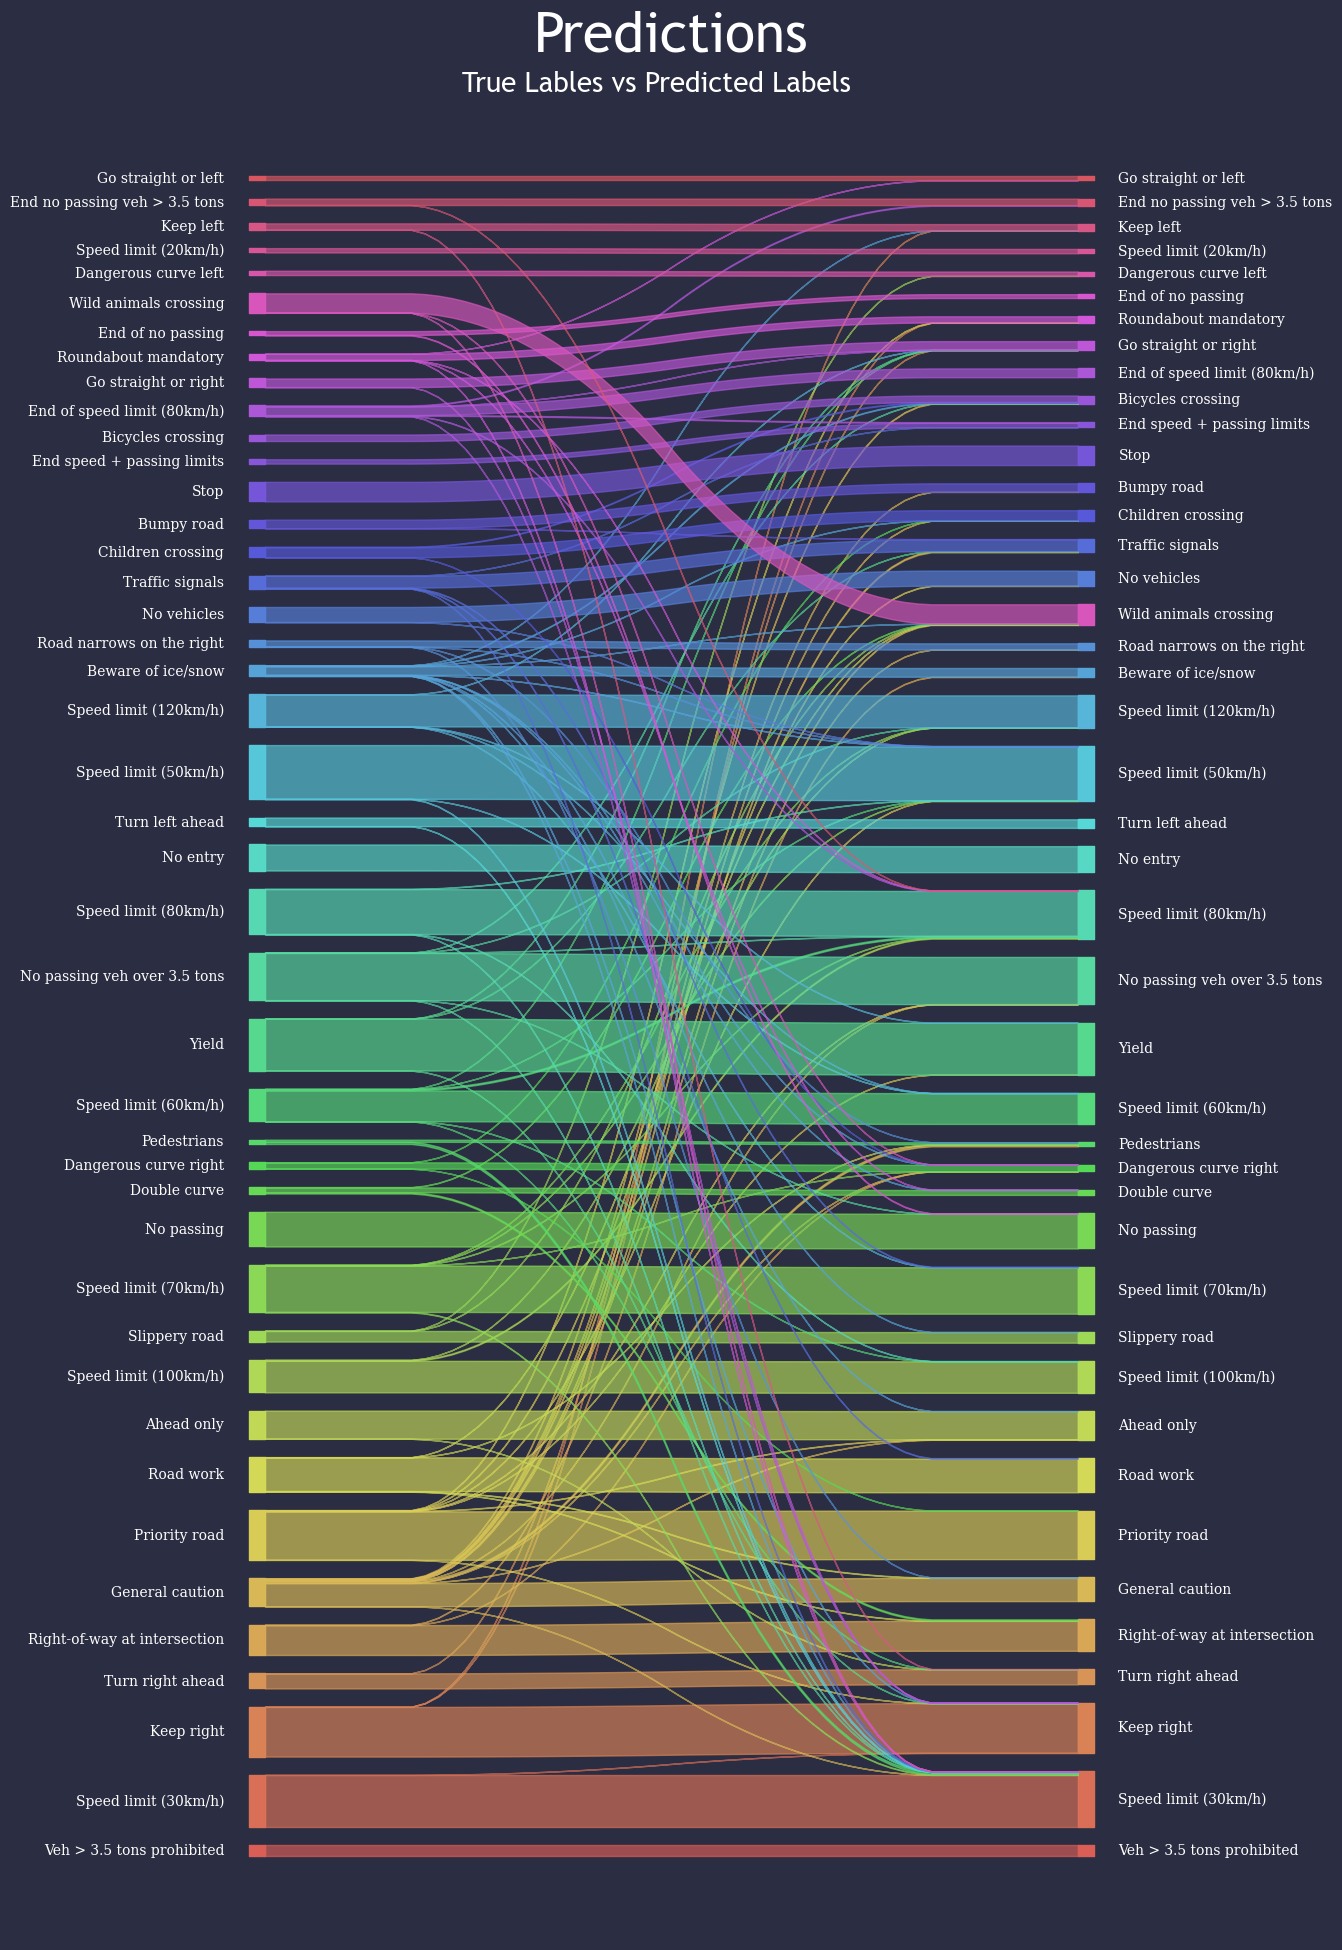

In [11]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Predictions_df = pd.DataFrame()
Predictions_df['True'] = y_test
Predictions_df['Pred'] = y_pred

Predictions_df['True'] = Predictions_df['True'].map(classes)
Predictions_df['Pred'] = Predictions_df['Pred'].map(classes)
Predictions_df.head()

sankey(
    left  = Predictions_df['True'], 
    right = Predictions_df['Pred'], 
    aspect=20, fontsize=10
)

# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 24)

# Set the color of the background to white
fig.set_facecolor("#2b2d42")

#font color to white
plt.rcParams['text.color'] = 'white'

plt.rcParams['axes.titlecolor'] = 'white'

plt.rcParams['axes.labelcolor'] = 'white'

plt.rcParams['axes.labelsize'] = 'large'

#Font to Trebuchet MS
plt.rcParams['font.family'] = 'Trebuchet MS'

#font size to 12
plt.rcParams['font.size'] = 30

#Title
plt.title("Predictions", fontsize=40, fontname='Trebuchet MS', pad=30)
#subtitle 
plt.suptitle("True Lables vs Predicted Labels", fontsize=20, fontname='Trebuchet MS', y=0.889)

fig.savefig("True_vs_Pred.png", bbox_inches="tight", dpi=800)

<a id="safeml"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>SafeML: Safety Monitoring through Statistical Distance Measure</b></div> 

## Comparing the true labels with predicted labels and using the statistical parametric mapping
<p style='text-align: justify;'> 
The idea of SafeML is to measure statistical distances and estimate the accuracy of the model when there is no available labels. Having an accuracy estimation at run time can be so vital for safety-critical applications. In this section, the statistical difference is addressed and the accuracy estimation will be considered on our later versions. Here, we simply find the test data where y_test is not equal to the predicted one (y_pred) and name it as X_test_wrong, y_test_wrong. Then for example, for label == 2, we compare the trained data (trusted data) and the X_test_wrong (selecting only label 2 ones for instance). Then using statistical parametric mapping, we try to find the statistical explanation to see what was different that our CNN model made a wronge decision. This explanation can be investigated in different perspectives and we just provide a sample.</p>

To find more about SafeML idea, please check our GitHub:

https://github.com/ISorokos/SafeML

1.6252239580647783
1.4836741476415878
1.4868302549894932


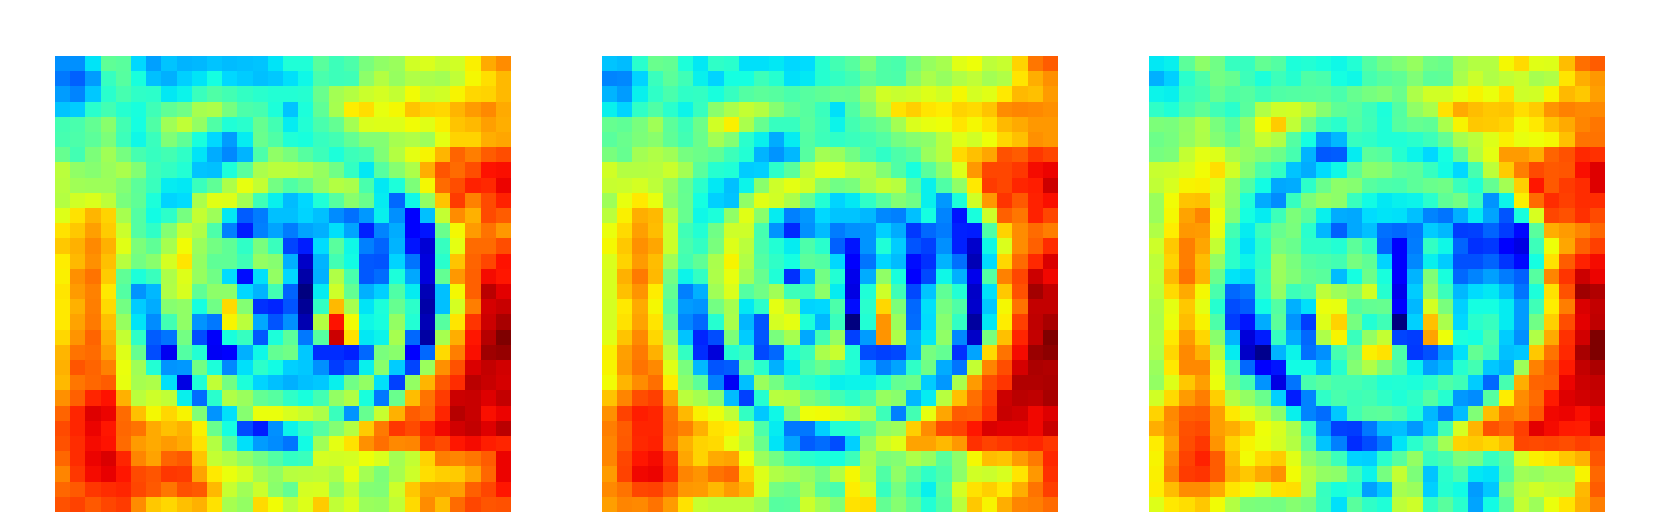

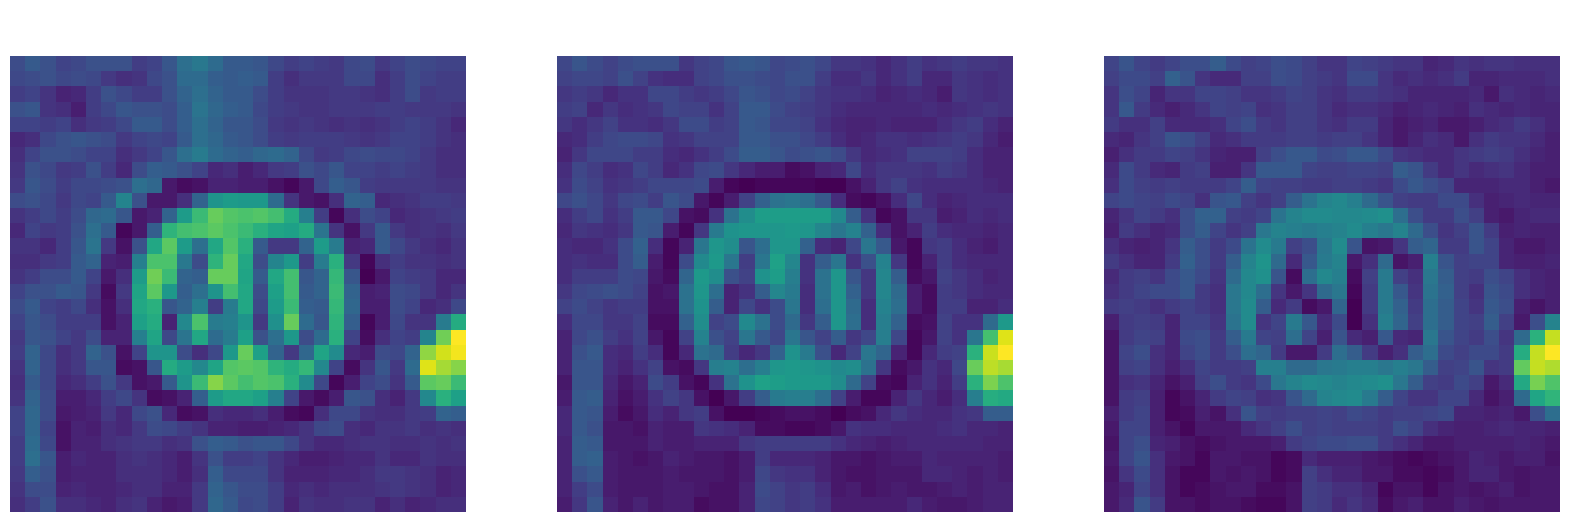

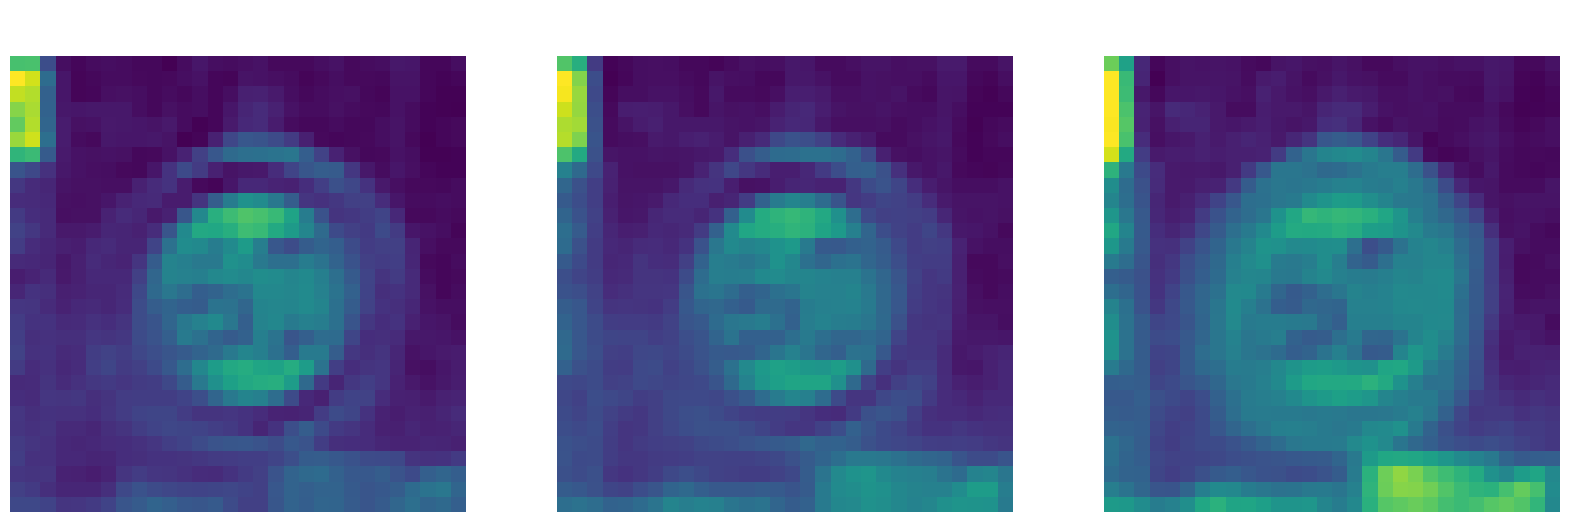

In [12]:
# Safety Monitoring through Statistical Parametric Mapping
!pip install spm1d
import os
from matplotlib import pyplot
import spm1d

# Separating Wrong Responses of the CNN Classifier
X_test_wrong, y_test_wrong = X_test[np.where(y_test != y_pred)], y_test[np.where(y_test != y_pred)]

# print(X_test_wrong.shape)

# Finding Wrong Decisions for Label 2 (just an example)
X_test_wrong3, y_test_wrong3 = X_test_wrong[np.where(y_test_wrong == 3)], y_test_wrong[np.where(y_test_wrong == 3)]

# print(X_test_wrong1.shape)

X_train3 = X_train[np.where(y_train[:,3] == 1)]


fig2, ax6 = pyplot.subplots(1,3, figsize = (20,6))

for ii, c_ax in enumerate(ax6.flatten()):
    # Comparing X_train for Label == 2 with X_Test_wronge for Label == 2
    xxx, yyy= X_train3[:,:,:,ii], X_test_wrong3[:,:,:,ii]
    xxx_2   = np.array([yy.flatten() for yy in xxx])
    yyy_2   = np.array([yy.flatten() for yy in yyy]) 
    snpm    = spm1d.stats.nonparam.ttest2(xxx_2[:30], yyy_2[:30])
    snpmi   = snpm.inference(0.05, two_tailed=True, iterations=1000) # Alpha is considered as 0.05
    
   # print(xxx_2.shape)
    J,Q     = xxx_2.shape
    z       = snpmi.z
    zstar   = snpmi.zstar
    z0      = np.zeros(Q)
    z0      = z
    Z0      = np.reshape(z0, (30,30))
    Z0i     = Z0.copy()
    Z0i[np.abs(Z0i)<zstar] = 0
    ZZ      = np.hstack( [Z0, Z0i] )
    
    print(1 - z[z != 0].mean())
    
    c_ax.imshow(Z0, 'jet') # Can be replaced with Z0i
    c_ax.set_title('RGB: {} of Set {} vs. Set {}'.format(ii, 1,2))
    c_ax.axis('off')

fig3, ax7 = pyplot.subplots(1,3, figsize = (20,6))    

for ii, c_ax in enumerate(ax7.flatten()):
    c_ax.imshow(X_train3[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, 3))
    c_ax.axis("off")
    
fig4, ax8 = pyplot.subplots(1,3, figsize = (20,6))     

for ii, c_ax in enumerate(ax8.flatten()):
    c_ax.imshow(X_test_wrong3[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test_wrong3[1]))
    c_ax.axis('off')

<a id="safeml"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Safety Monitoring through Statistical Parametric Mapping (SPM)</b></div>


900
900
900


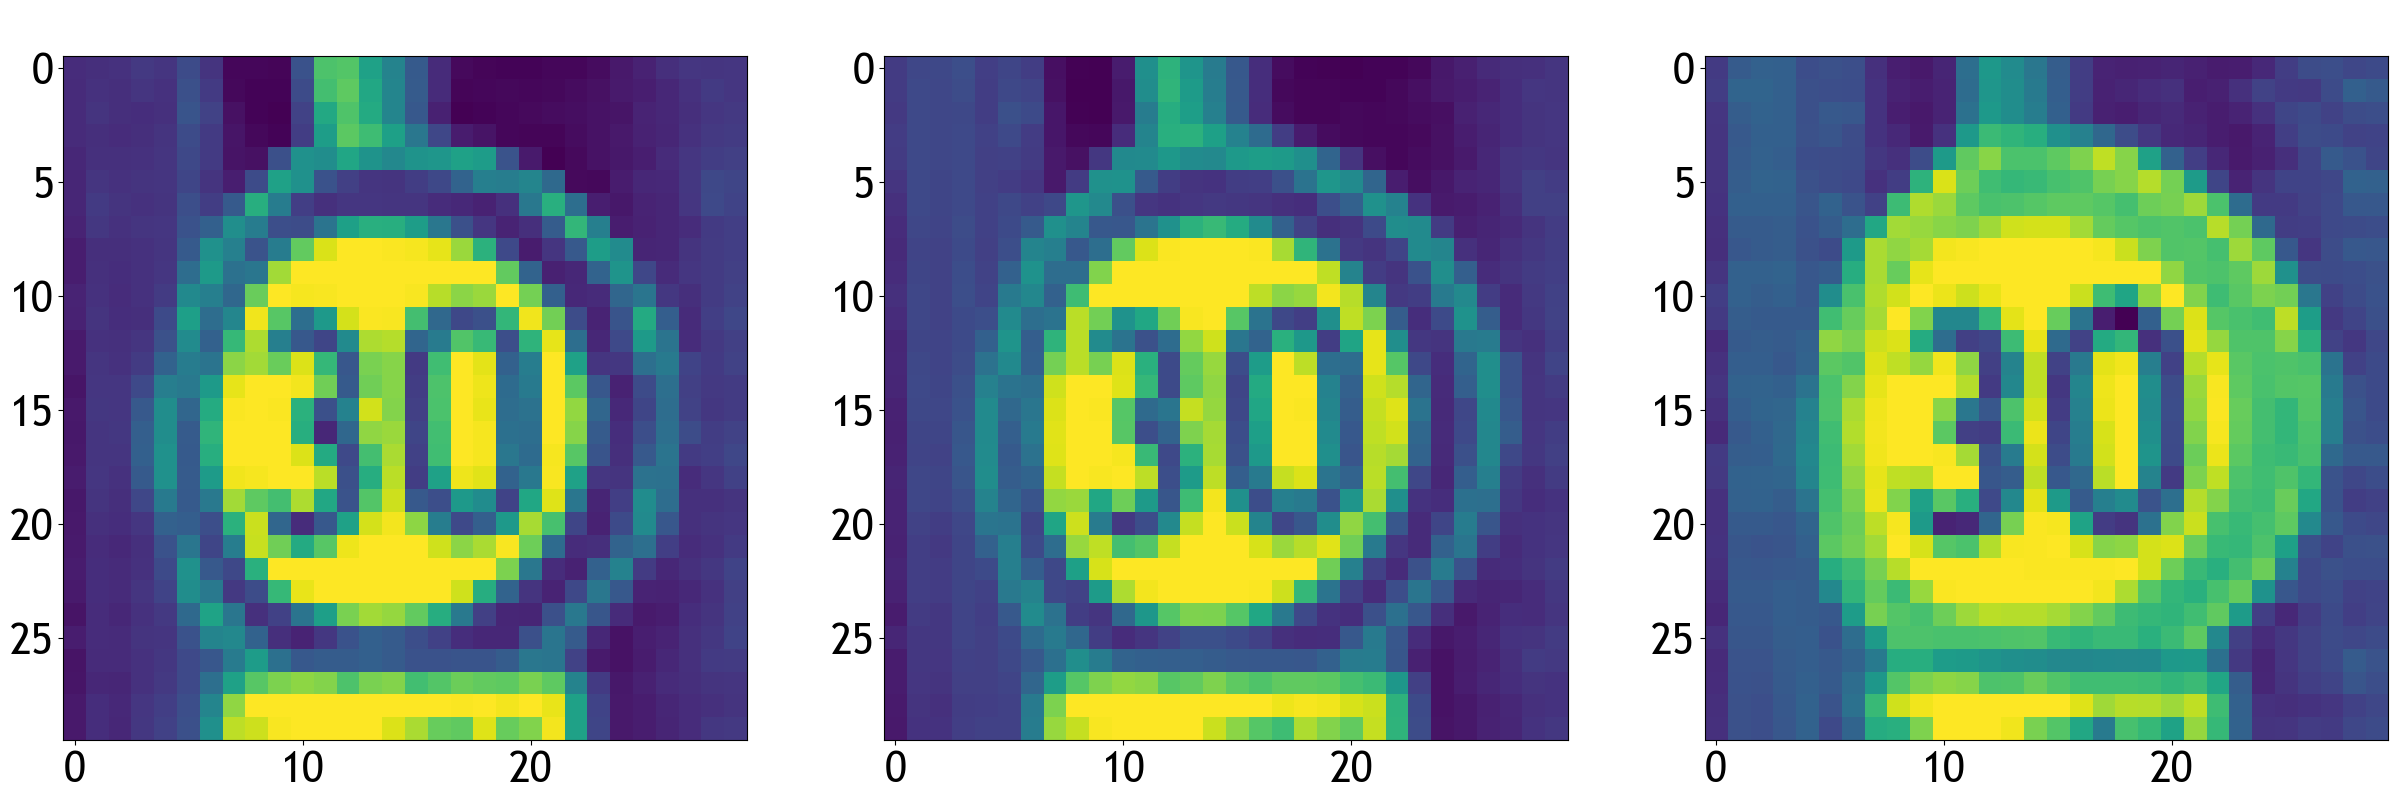

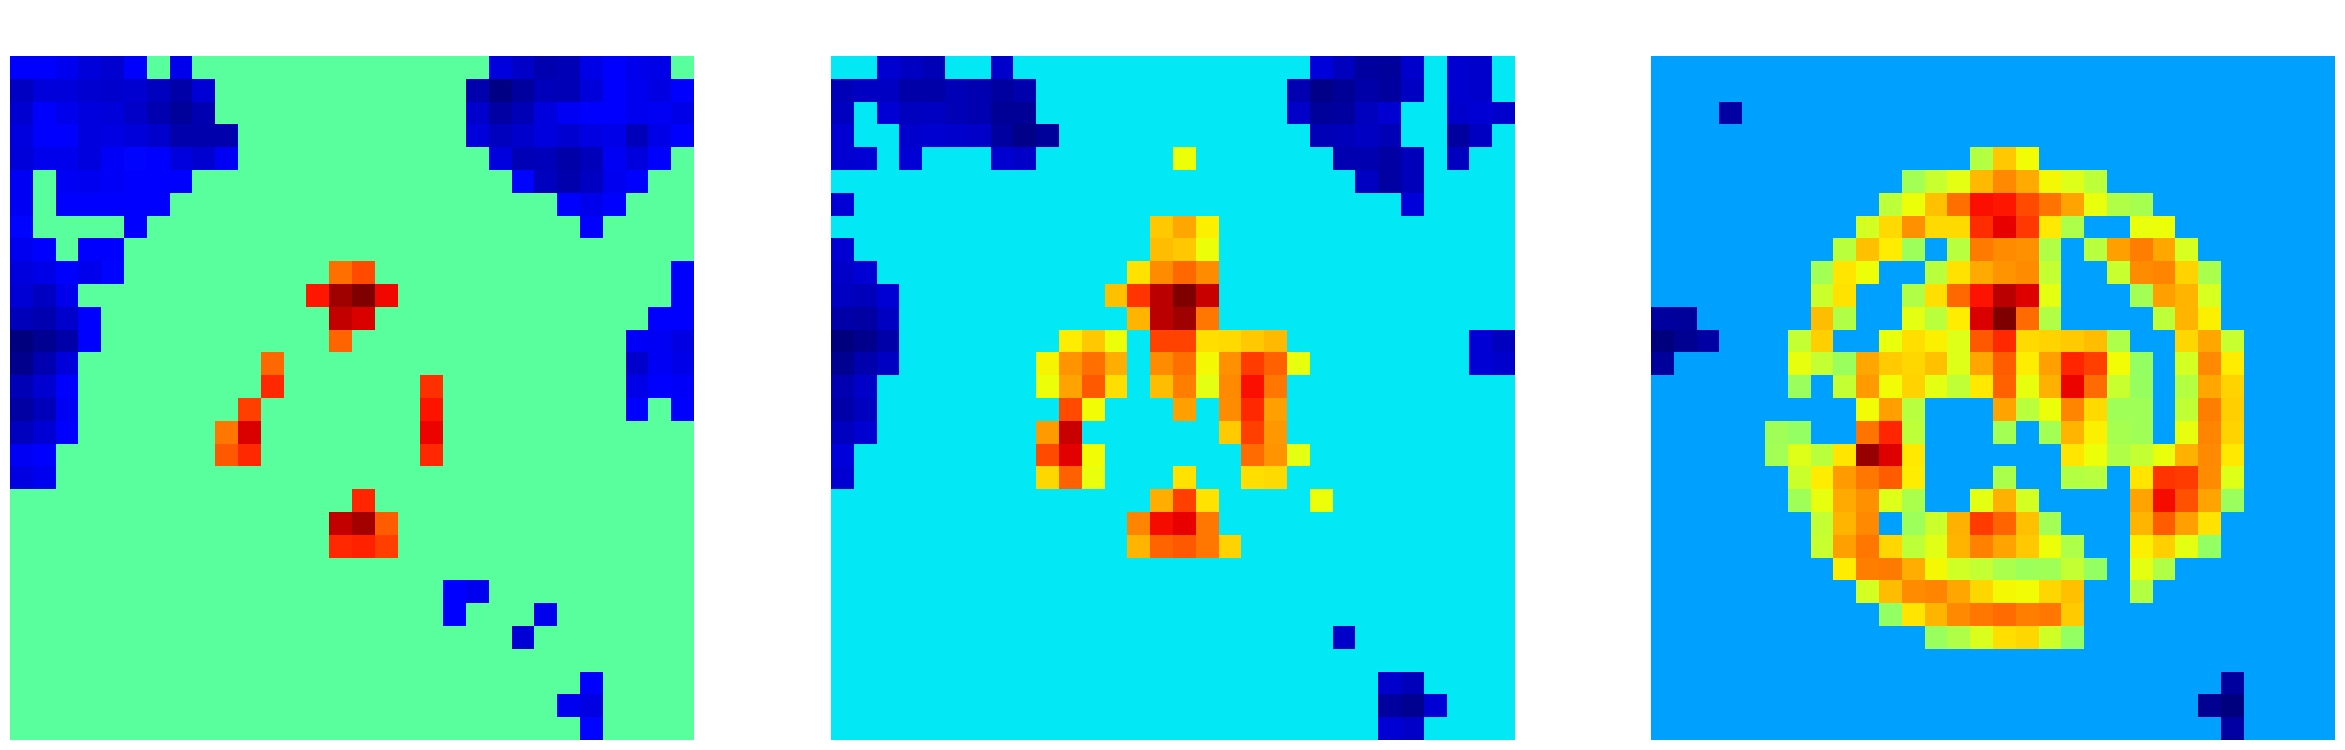

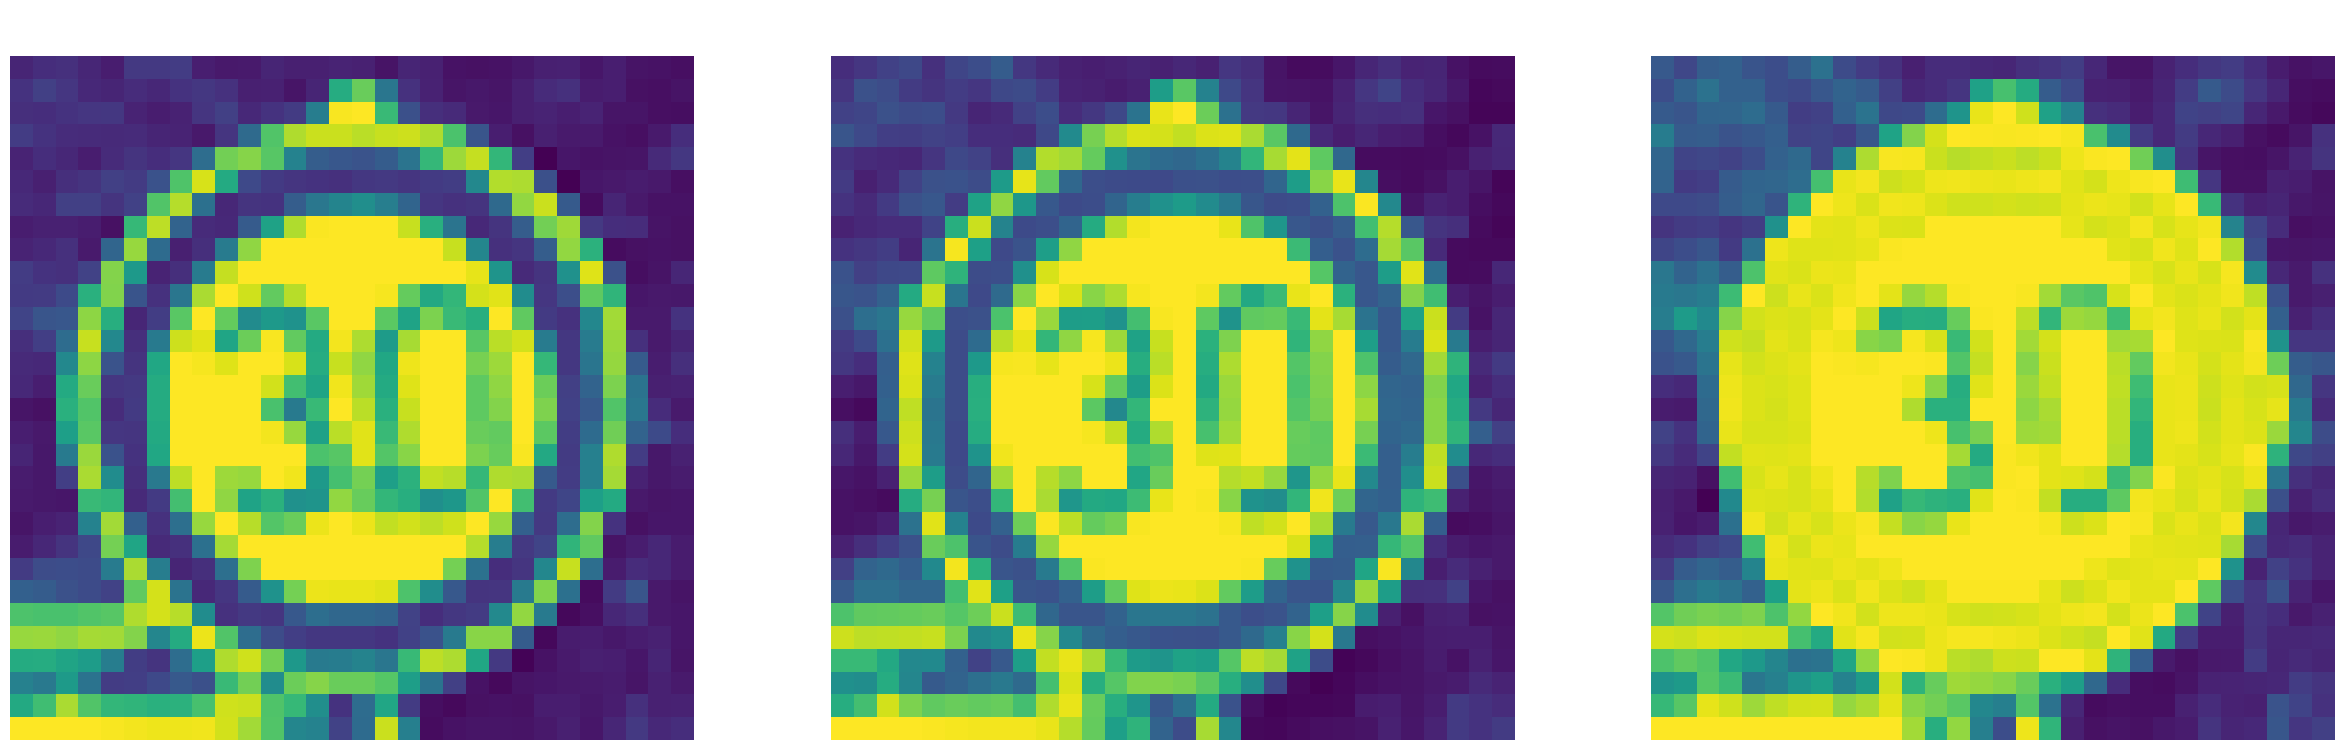

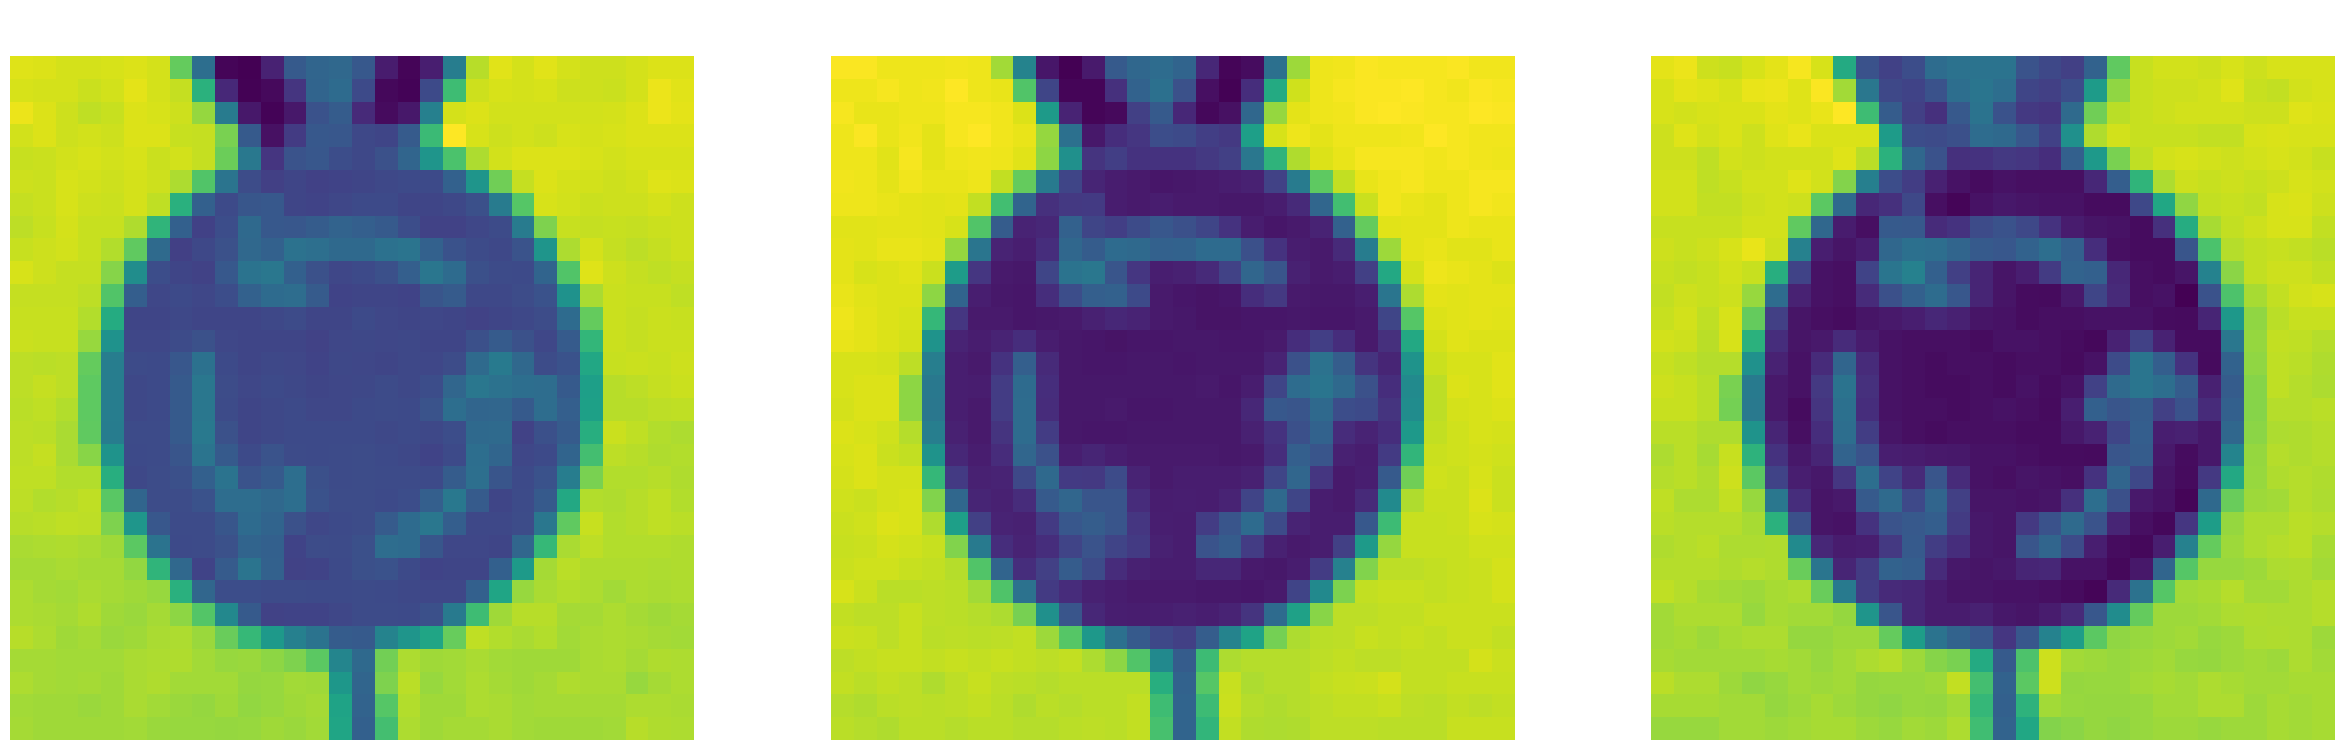

In [13]:
import os
from matplotlib import pyplot
import spm1d

fig, ax1 = plt.subplots(1,3, figsize = (30,12))

for ii, c_ax in enumerate(ax1.flatten()):
    c_ax.imshow(X_test[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test[1]))
    
X_train1, y_train1 = X_train[np.where(y_train[2,:] == 1)], y_train[np.where(y_train[2,:] == 1)]
X_test1, y_test1 = X_test[np.where(y_test == 1)], y_test[np.where(y_test == 1)]
X_test1_pred, y_test1_pred = X_test[np.where(y_pred == 40)], y_test[np.where(y_pred == 40)]

# print(X_test1.shape)

fig2, ax2 = pyplot.subplots(1,3, figsize = (30,10))

for ii, c_ax in enumerate(ax2.flatten()):
    xxx, yyy= X_test1[:,:,:,ii], X_test1_pred[:,:,:,ii]
    xxx_2   = np.array([yy.flatten() for yy in xxx])
    yyy_2   = np.array([yy.flatten() for yy in yyy]) 
    snpm    = spm1d.stats.nonparam.ttest2(xxx_2[:30], yyy_2[:30])
    snpmi   = snpm.inference(0.01, two_tailed=True, iterations=1000)
    
    print(xxx_2.shape[1])
    J,Q     = xxx_2.shape
    z       = snpmi.z
    zstar   = snpmi.zstar
    z0      = np.zeros(Q)
    z0      = z
    Z0      = np.reshape(z0, (30,30))
    Z0i     = Z0.copy()
    Z0i[np.abs(Z0i)<zstar] = 0
    ZZ      = np.hstack( [Z0, Z0i] )
    
    c_ax.imshow(Z0i, 'jet')
    c_ax.set_title('RGB: {} of Set {} vs. Set {}'.format(ii, 1,2))
    c_ax.axis('off')

fig3, ax3 = pyplot.subplots(1,3, figsize = (30,10))    

for ii, c_ax in enumerate(ax3.flatten()):
    c_ax.imshow(X_test1[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test1[1]))
    c_ax.axis('off')
    
fig4, ax4 = pyplot.subplots(1,3, figsize = (30,10))     

for ii, c_ax in enumerate(ax4.flatten()):
    c_ax.imshow(X_test1_pred[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test1_pred[1]))
    c_ax.axis('off')

<a id="wd"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Wasserstein Distance Measure</b></div> 

0.955603318250377
0.9401651376146789
0.9460440967283072


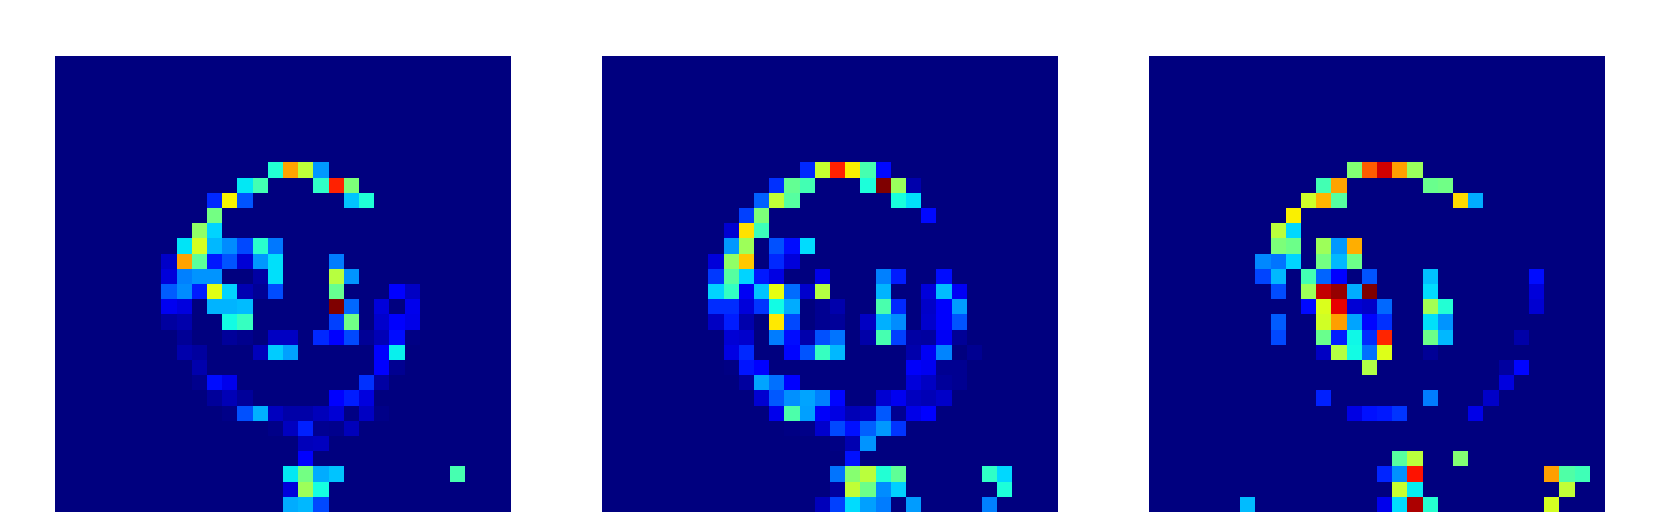

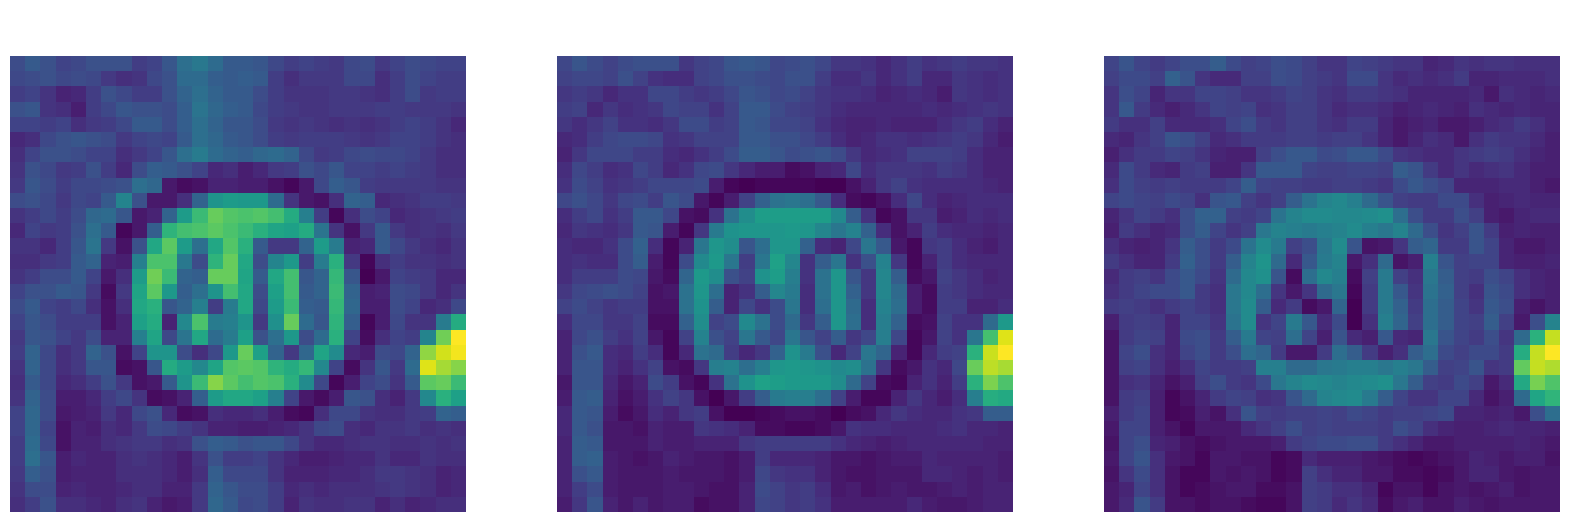

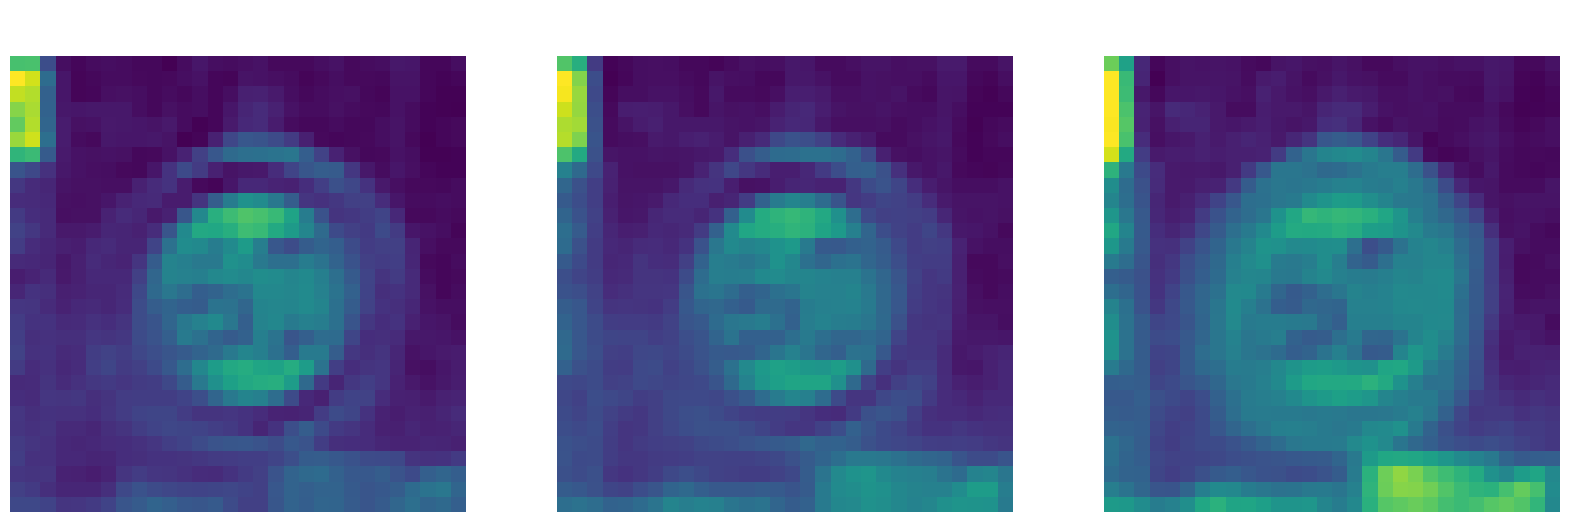

In [14]:
def Wasserstein_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;  
 
    return Res

def  Wasserstein_Dist_PVal(XX, YY):
    # Information about Bootstrap: https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    WD = Wasserstein_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_WD = Wasserstein_Dist(comb[e],comb[f]);
        if (boost_WD > WD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, WD

C_num = 3

# Separating Wrong Responses of the CNN Classifier
X_test_wrong, y_test_wrong = X_test[np.where(y_test != y_pred)], y_test[np.where(y_test != y_pred)]

# print(X_test_wrong.shape)

# Finding Wrong Decisions for Label 2 (just an example)
X_test_wrong3, y_test_wrong3 = X_test_wrong[np.where(y_test_wrong == C_num)], y_test_wrong[np.where(y_test_wrong == C_num)]

# print(X_test_wrong1.shape)

X_train3 = X_train[np.where(y_train[:,C_num] == 1)]

fig4, ax44 = pyplot.subplots(1,3, figsize = (20,6))
#fig5, ax55 = pyplot.subplots(1,3, figsize = (20,6))

for ii, c_ax44 in enumerate(ax44.flatten()):
    # Comparing X_train for Label == 2 with X_Test_wronge for Label == 2
    xxx, yyy= X_train3[:,:,:,ii], X_test_wrong3[:,:,:,ii]
    xxx_2   = np.array([yy.flatten() for yy in xxx])
    yyy_2   = np.array([yy.flatten() for yy in yyy]) 
    
    WD = np.zeros(900)
    pVal = np.zeros(900)
      
    for kk in range(1, 900):
        WD[kk], pVal[kk] = Wasserstein_Dist_PVal(xxx_2[:30,kk], yyy_2[:30,kk]) 
        
    WD2 = WD    

    print(1 - WD2[WD2 != 0].mean())
    #print(1 - WD2.mean())
    
    WD3 = WD
    WD3[pVal > 0.05] = 0
    
    J,Q     = xxx_2.shape
    z       = WD3
    zstar   = pVal #WD.mean()
    z0      = np.zeros(Q)
    z0      = z
    z1      = z0.copy()
    #z1[np.abs(z1)<zstar] = 0
    Z0      = np.reshape(z1, (30,30))
    #Z0i     = Z0.copy()
    #Z0i[np.abs(Z0i)<zstar] = 0
    #ZZ      = np.hstack( [Z0, Z0i] )
    
    z2      = WD
    Z02      = np.reshape(z2, (30,30))
    
    c_ax44.imshow(Z0, 'jet') # Can be replaced with Z0i
    c_ax44.set_title('RGB: {} of Set {} vs. Set {}'.format(ii, 1,2))
    c_ax44.axis('off')
    
fig5, ax55 = pyplot.subplots(1,3, figsize = (20,6))     

for ii, c_ax55 in enumerate(ax55.flatten()):
    c_ax55.imshow(X_train3[1,:,:,ii], interpolation = 'none')
    c_ax55.set_title('RGB: {} -- Test {}'.format(ii+1, 3))
    c_ax55.axis("off")
    
fig4, ax8 = pyplot.subplots(1,3, figsize = (20,6))     

for ii, c_ax in enumerate(ax8.flatten()):
    c_ax.imshow(X_test_wrong3[1,:,:,ii], interpolation = 'none')
    c_ax.set_title('RGB: {} -- Test {}'.format(ii+1, y_test_wrong3[1]))
    c_ax.axis('off')    

<a id="wic"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Calculating Wilson Interval Confidence</b></div> 

In [15]:
    # Kläs, M., & Sembach, L. (2019). Uncertainty wrappers for data-driven models. In International Conference on Computer Safety, Reliability, and Security. Springer.
    from math import sqrt
    def wilson(p, n, z = 3.29): # The z-score for a 95% confidence interval is 1.96.
        denominator = 1 + z**2/n
        centre_adjusted_probability = p + z*z / (2*n)
        adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)

        lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
        upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator

        return (lower_bound, upper_bound)


    X_test_correct, y_test_correct = X_test[np.where(y_test == y_pred)], y_test[np.where(y_test == y_pred)]

    X_test_correct3, y_test_correct3 = X_test_correct[np.where(y_test_correct == 3)], y_test_correct[np.where(y_test_correct == 3)]

    print(X_test_correct3.shape[0])
    print(X_test_wrong3.shape[0])

    print(1 - X_test_wrong3.shape[0]/X_test_correct3.shape[0])

    Negative = X_test_wrong3.shape[0] 
    total = X_test_wrong3.shape[0] + X_test_correct3.shape[0] 
    p  = 1 - Negative / total

    print(wilson(p, total))

426
24
0.9436619718309859
(0.9001753160628015, 0.9721748930516956)


<a id = "ref"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>References</b></div>

Amodei, D., Olah, C., Steinhardt, J., Christiano, P., Schulman, J., & Mané, D. (2016). Concrete problems in AI safety. arXiv preprint arXiv:1606.06565.

Aslansefat, K., Gogani, M. B., Kabir, S., Shoorehdeli, M. A., & Yari, M. (2020-a). Performance evaluation and design for variable threshold alarm systems through semi-Markov process. ISA transactions, 97, 282–295. https://doi.org/10.1016/j.isatra.2019.08.015

Aslansefat, K., Sorokos, I., Whiting, D., Kolagari, R. T., & Papadopoulos, Y. (2020-b). SafeML: Safety Monitoring of Machine Learning Classifiers through Statistical Difference Measure. arXiv preprint arXiv:2005.13166.

Balunovic, M., Baader, M., Singh, G., Gehr, T., & Vechev, M. (2019). Certifying Geometric Robustness of Neural Networks. In Advances in Neural Information Processing Systems (pp. 15287–15297).

Gehr, T., Mirman, M., Drachsler-Cohen, D., Tsankov, P., Chaudhuri, S., & Vechev, M. (2018, May). Ai2: Safety and robustness certification of neural networks with abstract interpretation. In IEEE Symposium on Security and Privacy (SP) (pp. 3–18). https://doi.org/10.1109/SP.2018.00058

Gulrajani, I., Ahmed, F., Arjovsky, M., Dumoulin, V., & Courville, A. C. (2017). Improved training of Wasserstein gans. In Advances in neural information processing systems (pp. 5767–5777).

Gheraibia, Y., Kabir, S., Aslansefat, K., Sorokos, I., & Papadopoulos, Y. (2019). Safety+ AI: A Novel Approach to Update Safety Models Using Artificial Intelligence. IEEE Access, 7, 135855–135869. https://doi.org/10.1109/ACCESS.2019.2941566

Kabir, S., Sorokos, I., Aslansefat, K., Papadopoulos, Y., Gheraibia, Y., Reich, J., … & Wei, R. (2019, October). A Runtime Safety Analysis Concept for Open Adaptive Systems. In International Symposium on Model-Based Safety and Assessment (pp. 332–346). Springer, Cham. https://doi.org/10.1007/978-3-030-32872-6_22

Scudellari, S. (2020) Hospitals Deploy AI Tools to Detect COVID-19 on Chest Scans, IEEE Spectrum.

Schulam, P., & Saria, S. (2019). Can you trust this prediction? Auditing pointwise reliability after learning. arXiv preprint arXiv:1901.00403.

Shen, J., Qu, Y., Zhang, W., & Yu, Y. (2018, April). Wasserstein distance guided representation learning for domain adaptation. In Thirty-Second AAAI Conference on Artificial Intelligence.

<a id = "git"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Related GitHub Projects</b></div>

Basic notebook: https://www.kaggle.com/lalithmovva/99-accuracy-on-german-traffic-sign-recognition

[SafeML Project](https://github.com/ISorokos/SafeML): The idea that has been briefly explained in this story.

[NN-Dependability-KIT Project](https://github.com/dependable-ai/nn-dependability-kit): Toolbox for software dependability engineering of artificial neural networks.

[Confident-NN Project](https://github.com/cfinlay/confident-nn): Toolbox for empirical confidence estimation in neural networks-based classification.

[SafeAI Project](https://eth-sri.github.io/research/safeai): Different toolboxes like DiffAI, DL2 and ERAN from SRILab ETH Zürich focusing on robust, safe and interpretable AI.

<center> <a href="#TOC" role="button" aria-pressed="true" >⬆️ Back to Table of Contents ⬆️</a>

<div style="border-radius:10px;border:#034914 solid;padding: 15px;background-color:aliceblue;font-size:90%;text-align:left">

<h4><b>Authors :</b> Koorosh Aslansefat </h4>  
    
<center> <strong> If you liked this Notebook, please do upvote. </strong>
    
<center> <strong> If you have any questions, feel free to put a comment! </strong>